In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df311 = pd.read_csv('raw/311_Customer_Service_Requests.csv')

D:\ProgramFiles\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df311.head()

,SRRecordID,ServiceRequesNum,SRType,Agency,Neighborhood,StreetAddress,ZipCode,MethodReceived,SRStatus,CreatedDate,StatusDate,DueDate,LastActivity,Outcome,LastActivityDate,GeoLocation
0,1094344940,15-00072082,WW Water Leak (Exterior),Bureau of Water and Waste Water,CANTON,1013 S CLINTON ST,21224,Interface,CLOSED,02/01/2015 08:12:00 AM +0000,02/01/2015 06:23:00 PM +0000,02/03/2015 08:12:00 AM +0000,Cityworks SR Comments,UPDATED,NaN,NaN
1,1094344982,15-00072083,BCLB-Liquor License Complaint,Liquor License Board,GREEKTOWN,500 S LEHIGH ST,21224,Interface,CLOSED,02/01/2015 08:48:00 AM +0000,02/18/2015 09:12:00 PM +0000,03/21/2015 07:48:00 AM +0000,Dispatch Investigator,Closed,NaN,NaN
2,1094345013,15-00072084,WW Hydrant Open,Bureau of Water and Waste Water,MILLHILL,2600 WILKENS AVE,21223,Phone,HOLDLOCK,02/01/2015 09:13:00 AM +0000,02/01/2015 11:07:00 AM +0000,02/02/2015 09:13:00 AM +0000,Cityworks SR Comments,UPDATED,NaN,NaN
3,1094345094,15-00072085,TRM-Snow/Icy Conditions,Department of Transportation,MEDFIELD,4496 83 N,21209,Phone,CLOSED,02/01/2015 09:24:00 AM +0000,02/04/2015 10:41:00 PM +0000,02/02/2015 09:24:00 AM +0000,Cityworks SR Comments,UPDATED,NaN,NaN
4,1094345124,15-00072086,TRM-Snow/Icy Conditions,Department of Transportation,EAST BALTIMORE MIDWAY,732 BARTLETT AVE,21218,Phone,CLOSED,02/01/2015 09:29:00 AM +0000,02/03/2015 09:09:00 PM +0000,02/02/2015 09:29:00 AM +0000,Cityworks SR Comments,UPDATED,NaN,NaN


# preprocessing

In [4]:
df311.SRType.fillna('NaN', inplace=True)
df311.GeoLocation.fillna('NaN', inplace=True)

categories related

In [5]:
df311['TypePrefixLen'] = df311.SRType.apply(lambda x: x.split('-')[0].split(' ').__len__())
df311['TypePrefix'] = df311.SRType.apply(lambda x: x.split('-')[0].split(' ')[0])
df311[df311.TypePrefixLen!=1].TypePrefix.value_counts()

WW             144988
Forestry        29530
RP               5211
Mayor's           978
DPW               487
zzz                20
zzzWW               7
zzzForestry         6
Name: TypePrefix, dtype: int64

datetime related

In [6]:

df311['date'] = df311.CreatedDate.apply(lambda x: x[:10])
df311['date'] = pd.to_datetime(df311['date'], format='%m/%d/%Y')

location related

In [7]:
def extract_coords(x):
    x=x.strip()
    if x is None:
        return None
    try:
        coords = eval(x.split('\n')[-1])
    except (NameError, SyntaxError):
        return None
    if isinstance(coords, tuple):
        return coords
    return None

In [8]:
# extract location
df311['coords'] = df311.GeoLocation.apply(extract_coords)
df311['Latitude'] = df311.coords.apply(lambda x: x[0] if x is not None else None)
df311['Longitude'] = df311.coords.apply(lambda x: x[1] if x is not None else None)

# categorical variable counts

In [5]:
srtype = df311.SRType.value_counts().to_frame()
srtype.columns = ['count']
srtype['percentage'] = srtype['count']/srtype['count'].sum()
# srtype

In [7]:
pa = df311.groupby(['TypePrefix', 'Agency']).count()[['SRRecordID']]
pa.columns = ['count']

# pa

In [29]:
srtypes = ['SW-Rat Rubout - Proactive', 'SW-Bulk-Scheduled', 'HCD-Sanitation Property', 'TRS-Parking Complaints', 'SW-Dirty Alley']

# Time series

In [30]:
min_date = df311['date'].min()
max_date = df311['date'].max()
temporal_df = pd.DataFrame(index=pd.date_range(min_date, max_date))
date_col = 'date'

In [31]:
temporal_df = temporal_df.join(df311.groupby(date_col).agg({date_col: 'count'}).rename(columns={date_col: 'ALL'}))

In [32]:
col = 'SRType'
for t in srtypes:
    temporal_df = temporal_df.join(
        df311[df311[col]==t].groupby(date_col).agg({date_col: 'count'}).rename(columns={date_col:col+'-'+t}))

time series


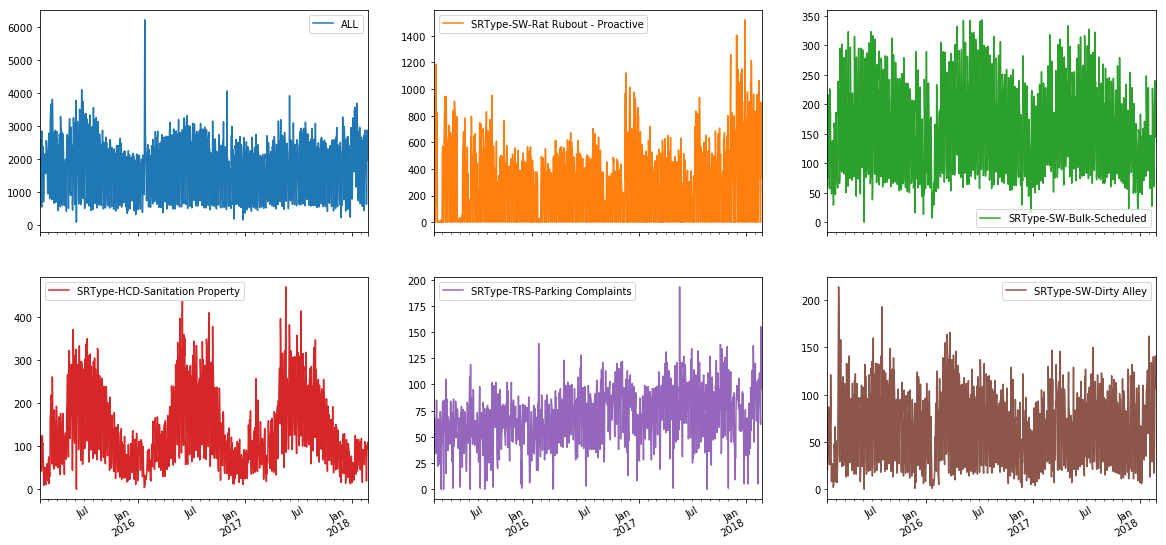

In [33]:
temporal_df.fillna(0).plot(subplots=True, layout=(2,3), figsize=(20,10))
print('time series')

# grid

In [34]:
from shapely.geometry import Point, box
import geopandas as gp
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot

In [35]:

def grid_line(mini, maxi, ngrid=10):
    delta = (maxi - mini) / ngrid
    return [(mini + i * delta, mini + (i + 1) * delta) for i in range(ngrid)]


def grid_area(w, s, e, n, ngrid=10):
    """
    grid area into ngrid^2 grids
    :param w, s, e, n,: the w, s, e, n (min_lon, min_lat, max_lon, max_lat) of the bound box
    :param ngrid: divide area into ngrid^2 grids
    :return: list of grid represented by bound box with s,w,n,e
    """
    grid_lat = grid_line(s, n, ngrid)
    grid_lon = grid_line(w, e, ngrid)
    grids = []
    for i in range(ngrid):
        for j in range(ngrid):
            si, ni = grid_lat[i]
            wj, ej = grid_lon[j]
            grids.append((wj, si, ej, ni))
    return grids

In [37]:
cityline = gp.read_file('raw/Baltcity_Line/baltcity_line.shp')
cityline.to_crs(epsg=3559, inplace=True)

In [39]:
gpdf_311 = df311[['Longitude', 'Latitude', 'SRType']]
gpdf_311 = gpdf_311[~gpdf_311.Longitude.isnull()]
gpdf_311['geometry'] = gpdf_311.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
gpdf_311 = gp.GeoDataFrame(gpdf_311.drop(['Longitude', 'Latitude'], axis=1), crs={'init': 'epsg:4326'})
gpdf_311.to_crs(cityline.crs, inplace=True)

In [54]:
line = cityline.geometry[0]
grids = grid_area(*line.bounds, ngrid=50)
wsen_poly = [box(*grid) for grid in grids]
wsen_poly = gp.GeoDataFrame(wsen_poly,columns=['geometry'], crs=cityline.crs)

distance between centroids of grids: 314.5389899998554


(-314.5389899999718, -388.1525280000933)

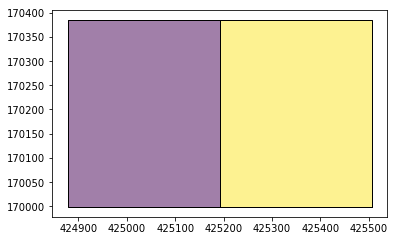

In [55]:
import math
[(a,b)] = wsen_poly.geometry[0].centroid.coords
[(c,d)] = wsen_poly.geometry[1].centroid.coords
print('distance between centroids of grids:', math.sqrt((a-c)**2+(b-d)**2))

wsen_poly[:2].plot()

a,b,c,d = wsen_poly.geometry[0].bounds
a-c, b-d

In [56]:
joined = gp.sjoin(gpdf_311, wsen_poly)

In [57]:
wsen_poly = wsen_poly.join(joined.groupby('index_right').agg({'SRType': 'count'}).rename(columns={'SRType':'ALL'}), how='inner')

In [58]:
df311.shape[0], gpdf_311.shape[0], joined.shape[0], wsen_poly.ALL.sum()

(2082156, 1954134, 1952844, 1952844)

In [59]:
col = 'SRType'
for t in srtypes:
    wsen_poly = wsen_poly.join(
        joined[joined[col]==t].groupby('index_right').agg({col: 'count'}).rename(columns={col: t}))

In [60]:
wsen_poly.fillna(0, inplace=True)

In [61]:
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#ffffcc'), (1, '#800026')])

In [62]:
wsen_poly

,geometry,ALL,SW-Rat Rubout - Proactive,SW-Bulk-Scheduled,HCD-Sanitation Property,TRS-Parking Complaints,SW-Dirty Alley
42,"POLYGON ((438402.9387764572 169997.5488773746,...",18,0.0,0.0,0.0,0.0,0.0
89,"POLYGON ((437459.3218064573 170385.7014053747,...",24,0.0,0.0,0.0,0.0,0.0
90,"POLYGON ((437773.8607964573 170385.7014053747,...",106,0.0,0.0,0.0,0.0,0.0
91,"POLYGON ((438088.3997864572 170385.7014053747,...",91,0.0,0.0,0.0,0.0,0.0
92,"POLYGON ((438402.9387764572 170385.7014053747,...",51,0.0,0.0,0.0,0.0,0.0
93,"POLYGON ((438717.4777664572 170385.7014053747,...",44,0.0,0.0,4.0,0.0,0.0
94,"POLYGON ((439032.0167564572 170385.7014053747,...",21,0.0,0.0,2.0,0.0,0.0
137,"POLYGON ((436830.2438264574 170773.8539333747,...",12,0.0,0.0,0.0,0.0,0.0
138,"POLYGON ((437144.7828164573 170773.8539333747,...",44,0.0,0.0,0.0,0.0,0.0
139,"POLYGON ((437459.3218064573 170773.8539333747,...",19,0.0,0.0,0.0,0.0,0.0


0 0
0 1
0 2
1 0
1 1
1 2


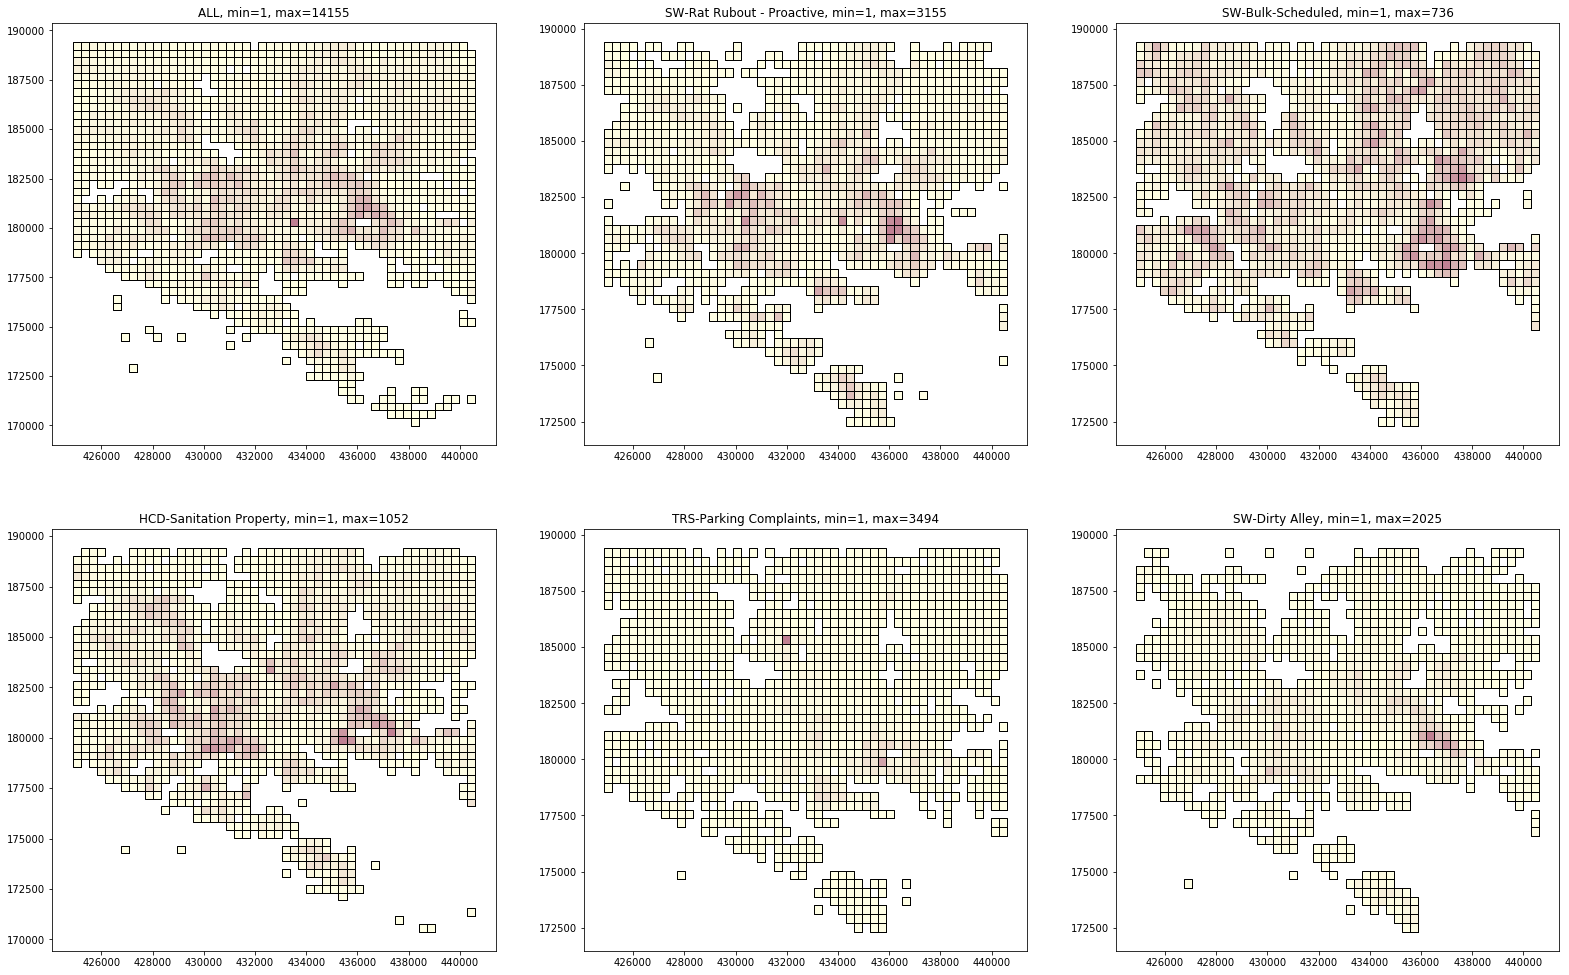

In [63]:
# fig, axes = pyplot.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(27, 18))
fig =pyplot.figure(figsize=(27,45))
for i, t in enumerate(['ALL'] + srtypes):
#     ax = axes[int(i/3)][i%3]
    print(int(i/3), i%3)
    ax = pyplot.subplot2grid((5,3), (int(i/3), i%3))
    mini, maxi = wsen_poly[wsen_poly[t]>0][t].min(), wsen_poly[t].max()
    ax.set_title('%s, min=%d, max=%d' % (t, mini, maxi))
    wsen_poly[wsen_poly[t]>0].plot(column=t, cmap=cmap, ax=ax, figsize=(9,9))
    

# Moran I

In [64]:
import pysal

In [65]:
wsen_poly.index = range(wsen_poly.shape[0])

In [66]:
# There are different kinds of distance weights
# e.g. K nearest neighbours
ks = [1,2,3,4,5,6,7,8, 9, 10]
ws_knn = {k: pysal.weights.KNN.from_dataframe(wsen_poly[['geometry']], k=k) for k in ks}

# e.g. distanct band
# There are 2 kinds of distant band weight, binary or non-binary. I don't know the exact difference between them. 
# with correct CRS, the unit of the following dbs is meter
dbs = [315, 650, 980, 1300]
ws_db_notbinary = {db: pysal.weights.DistanceBand.from_dataframe(wsen_poly[['geometry']], threshold=db, binary=False, silent=True) for db in dbs}
ws_db_binary = {db: pysal.weights.DistanceBand.from_dataframe(wsen_poly[['geometry']], threshold=db, binary=True, silent=True) for db in dbs}

D:\ProgramFiles\Anaconda3\lib\site-packages\scipy\sparse\data.py:103: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [67]:
# for KNN, every shape has k neighbors
# but for distance band, there are some islands which has no neighbors
# I choose 150 meter binary distance band weight in the cycling safety project considering the percentage of islands.
islands = [ws_db_binary[db].islands.__len__() for db in dbs]
pd.DataFrame(list(zip(dbs, islands)), columns=['band', 'num_islands']).set_index('band').T

band,315,650,980,1300
num_islands,32,5,2,1


In [68]:
def compute_moran_i(ws, param_list, x, pname):
    res = []

    for i, cname in enumerate(x):
        print('i=', i, cname)
            
        data = x[cname]
        for p in param_list:
            w = ws[p]
            mi = pysal.Moran(data, w, two_tailed=True, permutations=999)
            res.append({
                'column':cname, 
                pname:p,
                'I': mi.I, 
                'EI': mi.EI, 
                'p_norm': mi.p_norm * 2,
                'p_rand': mi.p_rand * 2,
                'z_norm': mi.z_norm,
                'z_rand': mi.z_rand,
            })
    print('done computing', pname)
    df = pd.DataFrame(res)
    return df[['column', pname, 'I', 'EI', 'p_norm', 'p_rand', 'z_norm', 'z_rand']]

In [69]:
# the function loop over each column of the features X. 
# It took quite a while for me to compute 200 features, maybe 1 hour or 2
# PySAL provides a function to compute moran I directly from a dataframe
# I don't know if that function would be faster

df_db_binary = compute_moran_i(ws_db_binary, dbs, wsen_poly.drop('geometry', axis=1), 'db_b')

i= 0 ALL
i= 1 SW-Rat Rubout - Proactive
i= 2 SW-Bulk-Scheduled
i= 3 HCD-Sanitation Property
i= 4 TRS-Parking Complaints
i= 5 SW-Dirty Alley
done computing db_b


In [70]:
df_db_binary.groupby(['column', 'db_b']).agg(lambda x: x)

I        EI  p_norm  p_rand     z_norm  \
column                    db_b                                                  
ALL                       315   0.675901 -0.000609     0.0     0.0  25.769469   
                          650   0.578689 -0.000609     0.0     0.0  47.715124   
                          980   0.483884 -0.000609     0.0     0.0  57.466414   
                          1300  0.402612 -0.000609     0.0     0.0  64.609443   
HCD-Sanitation Property   315   0.636235 -0.000609     0.0     0.0  24.258521   
                          650   0.522041 -0.000609     0.0     0.0  43.049215   
                          980   0.422706 -0.000609     0.0     0.0  50.210016   
                          1300  0.343921 -0.000609     0.0     0.0  55.205196   
SW-Bulk-Scheduled         315   0.598701 -0.000609     0.0     0.0  22.828810   
                          650   0.459392 -0.000609     0.0     0.0  37.888997   
                          980   0.366799 -0.000609     0.0     0.0  43.578893   
                          1300  0.294698 -0.000609     0.0     0.0  47.317965   
SW-Dirty Alley            315   0.742215 -0.000609     0.0     0.0  28.295521   
                          650   0.589325 -0.000609     0.0     0.0  48.591215   
                          980   0.456375 -0.000609     0.0     0.0  54.203596   
                          1300  0.345596 -0.000609     0.0     0.0  55.473533   
SW-Rat Rubout - Proactive 315   0.616512 -0.000609     0.0     0.0  23.507269   
                          650   0.518583 -0.000609     0.0     0.0  42.764385   
                          980   0.425612 -0.000609     0.0     0.0  50.554710   
                          1300  0.343504 -0.000609     0.0     0.0  55.138446   
TRS-Parking Complaints    315   0.409430 -0.000609     0.0     0.0  15.619139   
                          650   0.359598 -0.000609     0.0     0.0  29.669258   
                          980   0.299753 -0.000609     0.0     0.0  35.626376   
                          1300  0.242585 -0.000609     0.0     0.0  38.967725   

                                   z_rand  
column                    db_b             
ALL                       315   27.055403  
                          650   50.041688  
                          980   60.179101  
                          1300  67.500092  
HCD-Sanitation Property   315   25.427218  
                          650   45.074265  
                          980   52.494233  
                          1300  57.581282  
SW-Bulk-Scheduled         315   25.102602  
                          650   41.613114  
                          980   47.784434  
                          1300  51.750383  
SW-Dirty Alley            315   28.459931  
                          650   48.824753  
                          980   54.390017  
                          1300  55.544138  
SW-Rat Rubout - Proactive 315   24.151291  
                          650   43.890222  
                          980   51.811988  
                          1300  56.382394  
TRS-Parking Complaints    315   15.648733  
                          650   29.696022  
                          980   35.610383  
                          1300  38.866792